In [1]:
import paddle
from paddleocr import PaddleOCR,draw_ocr
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import pytesseract
from PIL import Image

/home/yegekucuk/venv/bitirme/lib/python3.12/site-packages/paddle/base/framework.py:688: UserWarning: You are using GPU version Paddle, but your CUDA device is not set properly. CPU device will be used by default.
  warnings.warn(
/home/yegekucuk/venv/bitirme/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if any GPU is available
gpu_available  = paddle.device.is_compiled_with_cuda()
print("GPU available:", gpu_available)

# Create OCR object and disable GPU to avoid CUDA issues
ocr = PaddleOCR(use_angle_cls=True, lang='en', use_gpu = False)

GPU available: True
[2025/03/23 00:13:29] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/home/yegekucuk/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/home/yegekucuk/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='

[2025/03/23 00:13:30] ppocr DEBUG: dt_boxes num : 65, elapsed : 0.3019993305206299
[2025/03/23 00:13:30] ppocr DEBUG: cls num  : 65, elapsed : 0.08414626121520996
[2025/03/23 00:13:33] ppocr DEBUG: rec_res num  : 65, elapsed : 3.238865613937378
[[[[[767.0, 174.0], [1520.0, 133.0], [1523.0, 187.0], [769.0, 228.0]], ('See back of receipt for your chance', 0.9458525776863098)], [[[772.0, 212.0], [1035.0, 206.0], [1036.0, 250.0], [773.0, 256.0]], ('to win $1000', 0.9475004076957703)], [[[775.0, 292.0], [902.0, 286.0], [903.0, 322.0], [776.0, 328.0]], ('ID#', 0.9549232125282288)], [[[935.0, 284.0], [1184.0, 273.0], [1186.0, 317.0], [937.0, 328.0]], ('7L0RX4K8PJX', 0.9648923277854919)], [[[873.0, 510.0], [1386.0, 480.0], [1392.0, 586.0], [879.0, 615.0]], ('Walmart', 0.9959738850593567)], [[[881.0, 622.0], [1396.0, 597.0], [1398.0, 649.0], [884.0, 674.0]], ('Save money.Live better.', 0.965684711933136)], [[[999.0, 707.0], [1396.0, 682.0], [1398.0, 726.0], [1001.0, 751.0]], ('937644-2800', 0.9

(-0.5, 2447.5, 2474.5, -0.5)

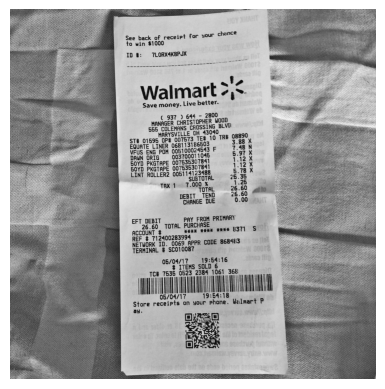

In [3]:
# Example 1

# Image path
image_path = "./kaggle/images/14.jpg"

# Open the image and apply image preprocessing
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply OCR
extracted_text_paddle = ocr.ocr(image, cls=True)
extracted_text_tesseract = pytesseract.image_to_string(image)
tesseract_data = pytesseract.image_to_data(image)

# Print
print(extracted_text_paddle)
print(extracted_text_tesseract)
print(tesseract_data)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))
plt.axis("off")

                                  text  confidence  \
0  See back of receipt for your chance    0.945853   
1                         to win $1000    0.947500   
2                                  ID#    0.954923   
3                          7L0RX4K8PJX    0.964892   
4                              Walmart    0.995974   

                                         coordinates  
0  [[767.0, 174.0], [1520.0, 133.0], [1523.0, 187...  
1  [[772.0, 212.0], [1035.0, 206.0], [1036.0, 250...  
2  [[775.0, 292.0], [902.0, 286.0], [903.0, 322.0...  
3  [[935.0, 284.0], [1184.0, 273.0], [1186.0, 317...  
4  [[873.0, 510.0], [1386.0, 480.0], [1392.0, 586...  


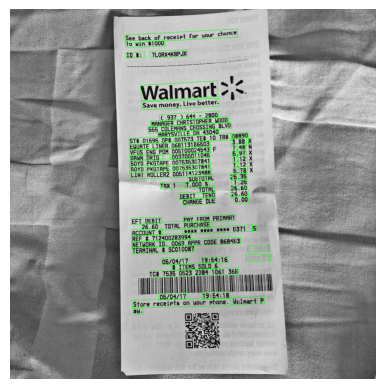

In [4]:
def process_ocr_result(ocr_result):
    processed = []
    for page in ocr_result:
        for line in page:
            if not line:  # Boş satırları atla
                continue
            coordinates, (text, confidence) = line
            processed.append({
                "text": text,
                "confidence": float(confidence),
                "coordinates": [[float(x[0]), float(x[1])] for x in coordinates]
            })
    return processed

# Process OCR results
processed_data = process_ocr_result(extracted_text_paddle)
# Create a pandas DataFrame
df = pd.DataFrame(processed_data)
print(df.head())

def visualize_results_paddle(image, processed_data):
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for item in processed_data:
        pts = np.array(item["coordinates"], dtype=np.int32)
        cv2.polylines(image, [pts], isClosed=True, color=(0,255,0), thickness=2)
        # cv2.putText(image, 
        #             f"{item['text']} ({item['confidence']:.2f})", 
        #             (int(pts[0][0]), int(pts[0][1]-5)), 
        #             cv2.FONT_HERSHEY_SIMPLEX, 
        #             0.5, 
        #             (0,0,255), 
        #             1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# Visualize results
visualize_results_paddle(image, processed_data)

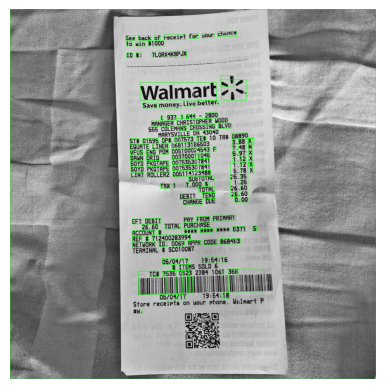

In [5]:
def visualize_results_tesseract(image, tesseract_data):
    # Görüntüyü BGR formatına dönüştür (PaddleOCR ile tutarlılık için)
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # Tesseract verisini satır satır işle
    lines = tesseract_data.splitlines()
    headers = lines[0].split('\t') if lines else []
    
    for line in lines[1:]:  # İlk satırı (başlık) atla
        components = line.split('\t')
        if len(components) < 12:
            continue

        level = int(components[0])
        if level != 5:  # Sadece kelime seviyesindeki kutuları al (level 5)
            continue

        # Koordinatları ve metni çıkar
        left = int(components[6])
        top = int(components[7])
        width = int(components[8])
        height = int(components[9])
        conf = components[10]
        text = components[11]

        # Kutu çiz
        cv2.rectangle(
            image,
            (left, top),
            (left + width, top + height),
            color=(0, 255, 0),
            thickness=2
        )

        # İsteğe bağlı: Metin ve güven skoru ekle (PaddleOCR'deki gibi)
        # cv2.putText(
        #     image,
        #     f"{text} ({conf})",
        #     (left, top - 5),
        #     cv2.FONT_HERSHEY_SIMPLEX,
        #     0.5,
        #     (0, 0, 255),
        #     1
        # )

    # Matplotlib ile gösterim için RGB'ye çevir
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# Kullanım örneği
import pytesseract
tesseract_data = pytesseract.image_to_data(image, output_type=pytesseract.Output.STRING)
visualize_results_tesseract(image, tesseract_data)

In [6]:
# Paddle

# Dokuman kaç sayfa?
print(len(extracted_text_paddle))
# Her sayfada kaç farklı metin çıkarılmış?
print(len(extracted_text_paddle[0]))
# Her sayfadaki tespit edilen metinlerin koordinatlarını tutan bir liste ve (metin,trust), 2 olmalı
print(len(extracted_text_paddle[0][0]))
# Koordinat sayısı, 4 olmalı
print(len(extracted_text_paddle[0][0][0]))
# Tuple, 2 olmalı
print(len(extracted_text_paddle[0][0][1]))
# İlk metini ve güven skorunu yazdıralım
print(f"Metin: {extracted_text_paddle[0][0][1][0]}")
print(f"Güven skoru: {extracted_text_paddle[0][0][1][1]}")

1
61
2
4
2
Metin: See back of receipt for your chance
Güven skoru: 0.9458525776863098
